<a href="https://colab.research.google.com/github/rs-delve/tti-explorer/blob/master/notebooks/tti-experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TTI Strategies

All of the information about the primary case's infection and how they infect their social contacts (under no government intervention) is now contained in `primary_case` and `social_contacts`.

Now we run a simulation, which works as follows. We start by generating a large number of cases, each with associated contacts. Given a particular strategy (e.g. test-based TTI with NPI of stringency level S3), each case is passed through the strategy, which computes various metrics for the case. For example, it computes the number of secondary cases due to primary case (reproduction number) and the number of tests required. We then collect the results for each case and average them, returning the final evaluation of the strategy.

## Running a Simulation

In [1]:
from emukit_new.core import DiscreteParameter, ContinuousParameter, ParameterSpace
# from emukit_new.sensitivity.monte_carlo import ModelFreeMonteCarloSensitivity
from emukit_new.core.initial_designs import RandomDesign
from emukit_new.model_wrappers import GPyModelWrapper
# from emukit_new.sensitivity.monte_carlo import MonteCarloSensitivity
from emukit_new.experimental_design.acquisitions import IntegratedVarianceReduction, ModelVariance
from emukit_new.experimental_design.experimental_design_loop import ExperimentalDesignLoop

In [2]:
!git clone https://github.com/rs-delve/tti-explorer.git
%cd tti-explorer
%pip install -q .

import os

import numpy as np
import pandas as pd
from tqdm.notebook import trange

from tti_explorer import config, utils
from tti_explorer.case import simulate_case, CaseFactors
from tti_explorer.contacts import EmpiricalContactsSimulator
from tti_explorer.strategies import TTIFlowModel, RETURN_KEYS

%pip install pyDOE
%pip install emukit
%pip install gpy
import urllib.request
import numpy as np
import matplotlib.pyplot as plt

urllib.request.urlretrieve('https://raw.githubusercontent.com/lawrennd/talks/gh-pages/teaching_plots.py','teaching_plots.py')
urllib.request.urlretrieve('https://raw.githubusercontent.com/lawrennd/talks/gh-pages/mlai.py','mlai.py')
urllib.request.urlretrieve('https://raw.githubusercontent.com/lawrennd/talks/gh-pages/gp_tutorial.py','gp_tutorial.py')


from matplotlib import colors as mcolors
from matplotlib import cm
import numpy as np
import GPy
# from emukit_new.core import DiscreteParameter, ContinuousParameter, ParameterSpace
# from emukit_new.sensitivity.monte_carlo import ModelFreeMonteCarloSensitivity
# from emukit_new.core.initial_designs import RandomDesign
from GPy.models import GPRegression
# from emukit_new.model_wrappers import GPyModelWrapper
# from emukit_new.sensitivity.monte_carlo import MonteCarloSensitivity
# from emukit_new.experimental_design.acquisitions import IntegratedVarianceReduction, ModelVariance
# from emukit_new.experimental_design.experimental_design_loop import ExperimentalDesignLoop
import matplotlib.pyplot as pltb
import teaching_plots as plot
import mlai
import pandas as pd

Cloning into 'tti-explorer'...
remote: Enumerating objects: 554, done.
remote: Counting objects: 100% (554/554), done.
remote: Compressing objects: 100% (261/261), done.
remote: Total 2667 (delta 396), reused 405 (delta 277), pack-reused 2113
Receiving objects: 100% (2667/2667), 31.55 MiB | 2.28 MiB/s, done.
Resolving deltas: 100% (1909/1909), done.
Checking connectivity... done.
/home/elim/Documents/Cambridge-Master/ML-PhyWorld/tti-le48/tti-explorer-with-changes/notebooks/elim/tti-explorer
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


We will analyse the `S3_test_based_TTI` strategy from our report. For clarity, we will show the whole process.

In [3]:
def load_csv(pth):
    return np.loadtxt(pth, dtype=int, skiprows=1, delimiter=",")

path_to_bbc_data = os.path.join("data", "bbc-pandemic")

over18 = load_csv(os.path.join(path_to_bbc_data, "contact_distributions_o18.csv"))
under18 = load_csv(os.path.join(path_to_bbc_data, "contact_distributions_u18.csv"))

First get the configurations:

In [4]:
name = 'S3_test_based_TTI'

case_config = config.get_case_config("delve")
contacts_config = config.get_contacts_config("delve")
policy_config = config.get_strategy_configs("delve", name)[name]

In [5]:
# 'asymp_factor' (contacts_config) 0.5-0.9
# 'p_day_noticed_symptoms' (p_day_noticed_symptoms) 1-5
# 'quarantine_length': 14, 5-14
#  'latent_period': 3, 1-5
# 'testing_delay': 2, 1-5

In [6]:
from scipy.stats import gamma

def update_case_config(p_day_noticed_symptoms_a):
    alpha = p_day_noticed_symptoms_a

    x = np.linspace(gamma.pdf(0.01, a=alpha),
                    gamma.pdf(0.99, a=alpha), 10)
    
    #apply softmax
    norm = np.exp(x)
    s = sum(norm)
    norm = np.round(norm/s, decimals=2)
    norm[-1] = 1- sum(norm[:-1])
    
    case_config['p_day_noticed_symptoms'] = norm
    return case_config

update_case_config(0.05)

{'p_under18': 0.21,
 'infection_proportions': {'dist': [0.8333333333333334,
   0.1,
   0.06666666666666667],
  'nppl': 120},
 'p_day_noticed_symptoms': array([0.36, 0.23, 0.15, 0.1 , 0.06, 0.04, 0.02, 0.02, 0.01, 0.01]),
 'inf_profile': [0.046966101377360424,
  0.15602255610429985,
  0.19829974712514023,
  0.18356485224565827,
  0.14541407040442172,
  0.10500447388376151,
  0.07130993362939089,
  0.04635772205156416,
  0.029167894888682697,
  0.017892648289720214]}

In [7]:
def update_contacts_config(asymp):
    contacts_config['asymp_factor'] = asymp
    return contacts_config
update_contacts_config(0.8)

{'home_sar': 0.3,
 'work_sar': 0.045,
 'other_sar': 0.045,
 'period': 10,
 'asymp_factor': 0.8}

In [8]:
def update_policy_config(quarantine, latent, testing):
    policy_config['quarantine_length'] = int(round(quarantine))
    policy_config['latent_period'] = int(round(latent))
    policy_config['testing_delay'] = int(round(testing))
    return policy_config

policy_config = update_policy_config(14, 3, 2)

In [9]:
# Separating this because it is built from the ammended policy_config
factor_config = utils.get_sub_dictionary(policy_config, config.DELVE_CASE_FACTOR_KEYS)
strategy_config = utils.get_sub_dictionary(policy_config, config.DELVE_STRATEGY_FACTOR_KEYS)

Set a random state:

In [10]:
rng = np.random.RandomState(42)

Make contact simulator:

In [11]:
simulate_contacts = EmpiricalContactsSimulator(over18, under18, rng)

Make the TTI Model:

In [12]:
tti_model = TTIFlowModel(rng, **strategy_config)

Generate cases, contacts and run simulation:

In [13]:
"""
Runs TTI simulator as many times as the different input initialisations.
The main reason we need this is to put in to EmuKit for the Experimental
Design Loop.

Args:
    configs (list): Inputs are [app_cov, compliance]

Returns:
    effective_rs (np.expand_dims(np.array(to_return), 1)): For every simulation run, return
    the effective r, as was plotted form Bryn and Andrei previously.

"""
rng = np.random.RandomState(42)
simulate_contacts = EmpiricalContactsSimulator(over18, under18, rng)

def run_tti_sim(configs):
    to_return=[]
    for vals in configs:
#         contact_config = update_case_config(vals[0])
#         case_config = update_case_config(vals[1])
        policy_config = update_policy_config(vals[0],vals[1], vals[2])
        factor_config = utils.get_sub_dictionary(policy_config, config.DELVE_CASE_FACTOR_KEYS)
        strategy_config = utils.get_sub_dictionary(policy_config, config.DELVE_STRATEGY_FACTOR_KEYS)
        tti_model = TTIFlowModel(rng, **strategy_config)
        n_cases = 10000
        outputs = list()
        temp =[]
        for _ in trange(n_cases):
            case = simulate_case(rng, **case_config)
            case_factors = CaseFactors.simulate_from(rng, case, **factor_config)
            contacts = simulate_contacts(case, **contacts_config)
            res = tti_model(case, contacts, case_factors)
            outputs.append(res)
            if res["Effective R"] >= 0:
                temp.append(res["Effective R"]) # Get effective R. Only non-nan vals are kept
        to_return.append(np.mean(temp))
    return np.expand_dims(np.array(to_return), 1)


In [14]:
# 'asymp_factor' (contacts_config) 0.5-0.9
# 'p_day_noticed_symptoms' (case_config) 1-5
# 'quarantine_length': 14, 10-14
#  'latent_period': 3, 1-5
# 'testing_delay': 2, 1-5

# variable_domain1 = [0.05, 2] 
# variable_domain2 = [1, 5]
variable_domain3 = [10,11,12,13,14] 
variable_domain4 = [3,4,5,6,7,8] 
variable_domain5 = [1,2,3,4,5] 

initial_samples = 10 # number of random runs to perform before starting experimental design 
space = ParameterSpace([
#     ContinuousParameter('asymp_factor', *variable_domain1),
#                         ContinuousParameter('p_day_noticed_symptoms', *variable_domain2),
                        DiscreteParameter('quarantine_length', variable_domain3),
                        DiscreteParameter('latent_period', variable_domain4),
                        DiscreteParameter('testing_delay', variable_domain5)]) # init param space for experimental design
design = RandomDesign(space)
x = design.get_samples(initial_samples) # get 5 random combinations of initialisations
y = run_tti_sim(x) # obtain corresponding effective_rs

In [15]:
# Fitting emulator to data, x: (app_cov, compliance), y: effective_r
Num_of_param = 3
kern_eq = GPy.kern.RBF(input_dim=Num_of_param, ARD = True)
kern_bias = GPy.kern.Bias(input_dim=Num_of_param)
kern = kern_eq + kern_bias
model_gpy = GPRegression(x,y, kern)
model_gpy.kern.variance = 1**2
model_gpy.likelihood.variance.fix(1e-5)
model_emukit = GPyModelWrapper(model_gpy) 
model_emukit.optimize() # optimise (max log-lik)
display(model_gpy)

Optimization restart 1/1, f = -8.518097568638368


GP_regression.,value,constraints,priors
sum.rbf.variance,0.010284377704102511,+ve,
sum.rbf.lengthscale,"(3,)",+ve,
sum.bias.variance,2.4344865048365425,+ve,
Gaussian_noise.variance,1e-05,+ve fixed,


In [16]:
# Initialise experimental design loop. Using integrated variance as acquisition
# to "query" the input space aiming to reduce uncertainty over the func we're approx. i.e. effective_r
num_of_loops = 5
integrated_variance = IntegratedVarianceReduction(space=space, model=model_emukit)
ed = ExperimentalDesignLoop(space=space, model=model_emukit, acquisition = integrated_variance)
ed.run_loop(run_tti_sim, num_of_loops)

Optimization restart 1/1, f = -8.518097568777453



Optimization restart 1/1, f = -9.736152938471857



Optimization restart 1/1, f = -11.239078719968912



Optimization restart 1/1, f = -12.230700831803265



Optimization restart 1/1, f = -13.706326521528212



Optimization restart 1/1, f = -15.086152035444915


## Calculate Sobol indices with SALib
Discretizing the input factor should not affect the Sobol and FAST methods.
https://waterprogramming.wordpress.com/2014/02/11/extensions-of-salib-for-more-complex-sensitivity-analyses/

In [17]:
from SALib.sample import saltelli
from SALib.analyze import sobol

# 'asymp_factor' (contacts_config) 0.5-0.9
# 'p_day_noticed_symptoms' (case_config) 1-5
# 'quarantine_length': 14, 10-14
#  'latent_period': 3, 1-5
# 'testing_delay': 2, 1-5

# problem = {
# 'num_vars': 5,
# 'names': ['asymp_factor', 'p_day_noticed_symptoms', 'quarantine_length','latent_period','testing_delay'],
# 'bounds': [[0.05, 2],
#             [1, 5],
#             [10,14], 
#             [3,8],
#             [1,5]]
# }
problem = {
'num_vars': 3,
'names': ['quarantine_length','latent_period','testing_delay'],
'bounds': [
            [10,14], 
            [3,8],
            [1,5]]
}


xt = saltelli.sample(problem, 11000)
Y,_= model_gpy.predict(xt)
Y = np.squeeze(Y)

Si = sobol.analyze(problem, Y)
print(Si['S2'])

[[        nan -0.00167449  0.33974992]
 [        nan         nan  0.01043556]
 [        nan         nan         nan]]


In [18]:
print(Si['S1'])

[0.01988766 0.00250023 0.62504872]


## Calculate Sobol indices with Emukit_new

In [19]:
from emukit_new.sensitivity.monte_carlo import ModelFreeMonteCarloSensitivity
from emukit_new.sensitivity.monte_carlo import MonteCarloSensitivity
from emukit_new.sensitivity.monte_carlo import MonteCarloSecondOrderSensitivity

senstivity = MonteCarloSecondOrderSensitivity(model = model_emukit, input_domain = space)

main_effects_gp, secondary_effects_gp, total_effects_gp, _ = senstivity.compute_effects(num_monte_carlo_points = 1000)

Text(0.5, 1.0, 'First Order Sobol Indices')

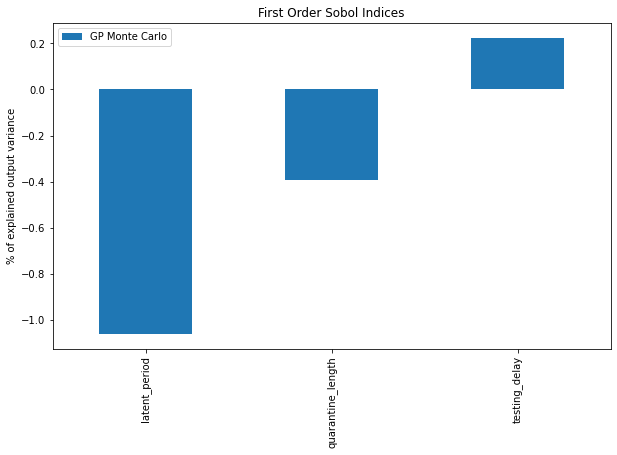

In [20]:
# Plot Main Effects
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
main_effects_gp_plot = {ivar: main_effects_gp[ivar][0] for ivar in main_effects_gp}

d = {'GP Monte Carlo':main_effects_gp_plot}

pd.DataFrame(d).plot(kind='bar', ax=ax)
plt.ylabel('% of explained output variance')

ax.set_title("First Order Sobol Indices")

Text(0.5, 1.0, 'Second Order Sobol Indices')

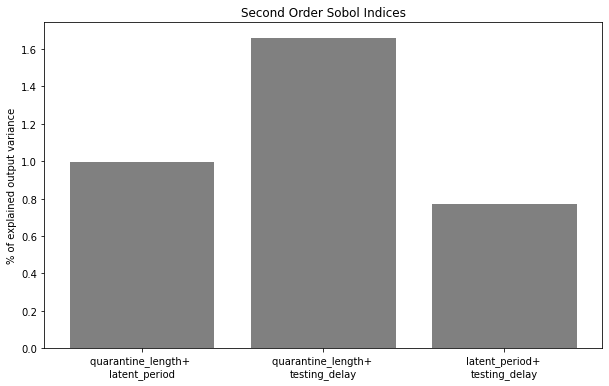

In [21]:
# Plot Second Order Effects
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
secondary_effects_gp_plot = {ivar: secondary_effects_gp[ivar] for ivar in secondary_effects_gp}

for ivar in secondary_effects_gp:
    ax.bar(ivar,secondary_effects_gp[ivar], color = 'grey')
    
plt.ylabel('% of explained output variance')   
ax.set_title("Second Order Sobol Indices")

Text(0.5, 1.0, 'Total Effects')

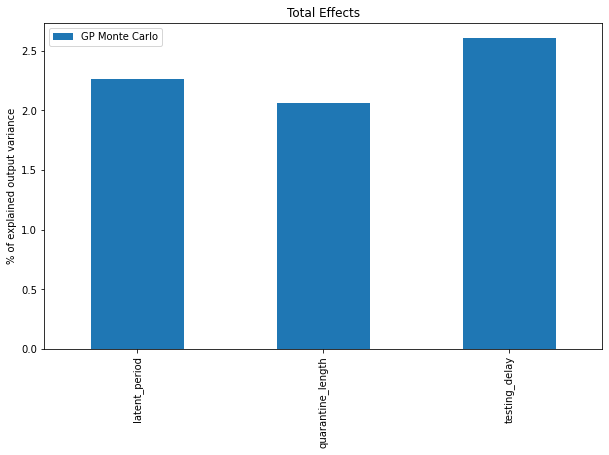

In [22]:
# Plot Total Effects
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
total_effects_gp_plot = {ivar: total_effects_gp[ivar][0] for ivar in main_effects_gp}

d = {'GP Monte Carlo':total_effects_gp_plot}

pd.DataFrame(d).plot(kind='bar', ax=ax)
plt.ylabel('% of explained output variance')

ax.set_title("Total Effects")